In [8]:
import os
os.chdir('/home/hugo-dev/esirem-dev/4a/kmutt/kmutt_v2')

In [16]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils.load_data import load_data
from utils.plot_history import plot_history

In [10]:
DATA_PATH = "./data/data_2s_6mfcc_RMT-HRK.json"
SAVED_MODEL_PATH = "./models/cnn1d/model.keras"
EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [11]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    # load dataset
    X, y = load_data(data_path)

    # initialisez le scaler
    scaler = MinMaxScaler()

    # redimensionnez X en 2D pour le scaling
    X_2d = X.reshape(-1, X.shape[-1])

    # ajustez et transformez les données
    X_scaled = scaler.fit_transform(X_2d)

    # redimensionnez X à sa forme originale
    X_normalized = X_scaled.reshape(X.shape)

    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [12]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(tf.keras.layers.MaxPooling1D(2))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'))
    model.add(tf.keras.layers.Dropout(0.3))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))

    # softmax output layer
    model.add(tf.keras.layers.Dense(2, activation='softmax'))

    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

In [13]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model

    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set

    :return history: Training history
    """

    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

Training sets loaded!
(1572, 101, 6)


/home/hugo-dev/esirem-dev/4a/kmutt/kmutt_v2/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 101, 32)        │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 416,802 (1.59 MB)

 Trainable params: 416,802 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6458 - loss: 0.6438 - val_accuracy: 0.8553 - val_loss: 0.4631
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8460 - loss: 0.4208 - val_accuracy: 0.8528 - val_loss: 0.3230
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8706 - loss: 0.3377 - val_accuracy: 0.8706 - val_loss: 0.2971
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8706 - loss: 0.3116 - val_accuracy: 0.8452 - val_loss: 0.2997
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8837 - loss: 0.2928 - val_accuracy: 0.8655 - val_loss: 0.2795
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8806 - loss: 0.2717 - val_accuracy: 0.8655 - val_loss: 0.2727
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8716 - loss: 0.3085 - val_accuracy: 0.8579 - val_loss: 0.2793
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8879 - loss: 0.2787 - val_accuracy: 0.8655 - v

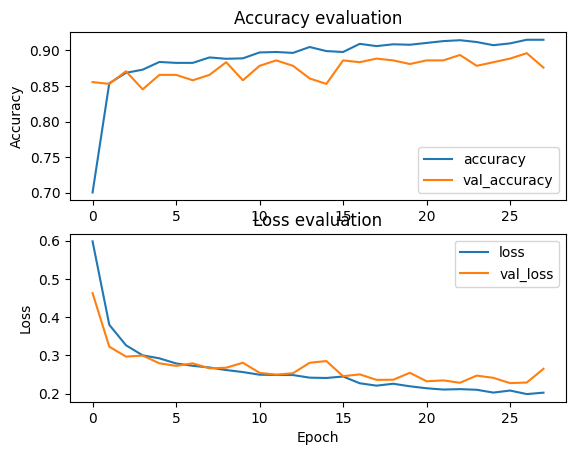

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9207 - loss: 0.2041

Test loss: 0.2093934714794159, test accuracy: 91.66666865348816


In [14]:
# generate train, validation and test sets
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)

print(X_train.shape)

# create network
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape, learning_rate=LEARNING_RATE)

# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)

# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

# save model
model.save(SAVED_MODEL_PATH)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Recall: 0.914187643020595, F1 Score: 0.9144612696810743


Text(95.72222222222221, 0.5, 'Vrai')

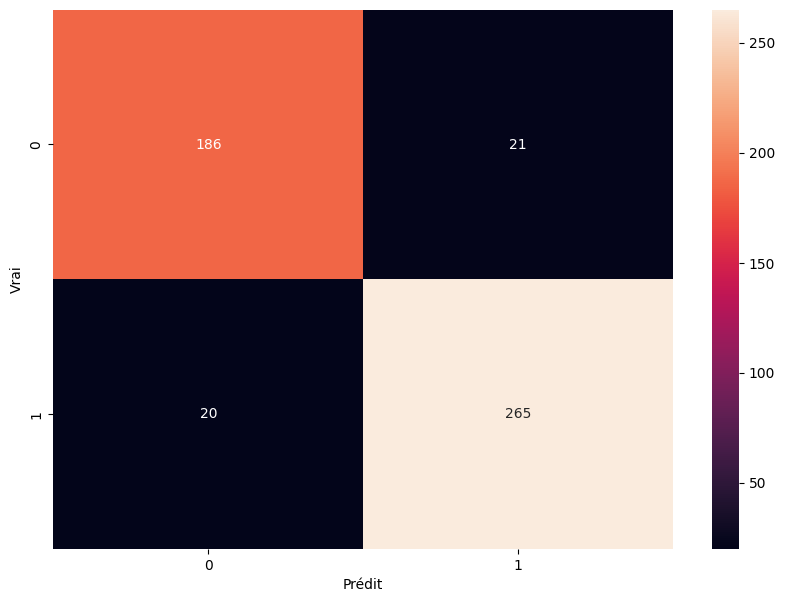

In [15]:
from sklearn.metrics import recall_score, f1_score, confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

recall = recall_score(y_test, y_pred_classes, average='macro')
f1 = f1_score(y_test, y_pred_classes, average='macro')
cm = confusion_matrix(y_test, y_pred_classes)

print("\nRecall: {}, F1 Score: {}".format(recall, f1))

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prédit')
plt.ylabel('Vrai')